In [1]:
# Here is a classical max cut QAOA inspired from:
#  https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
#  https://qiskit.org/textbook/ch-applications/qaoa.html
#  https://lucaman99.github.io/new_blog/2020/mar16.html

In [34]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from scipy.optimize import minimize

In [3]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

/Users/voicutu/opt/anaconda3/envs/qosf_ment/lib/python3.7/site-packages/qiskit/quantum_info/operators/pauli.py:107: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
/Users/voicutu/opt/anaconda3/envs/qosf_ment/lib/python3.7/site-packages/qiskit/quantum_info/operators/pauli.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

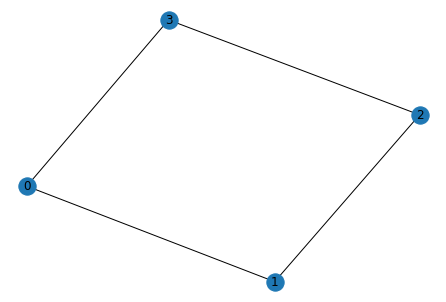

In [4]:

#Example:#
graph=[(0, 1,1.0), (0, 3,1.0), (1, 2,1.0), (2, 3,1.0)] 
nr_nodes=4

G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [20]:
#brut force  for verification  :
def brut_MaxCut(graph,nr_nodes):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]       


    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(nr_nodes)))]
        cost=0
        for i in range(nr_nodes):
            for j in range(nr_nodes):
                cost=cost+W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            for i in range(len(x)):
                x[i]=str(x[i])
            max_str.append(''.join(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            for i in range(len(x)):
                x[i]=str(x[i])
            max_str.append(''.join(x))
 
            
    return  max_str, best_cost_brute
            
#Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=33.0): 
 
110010
001101


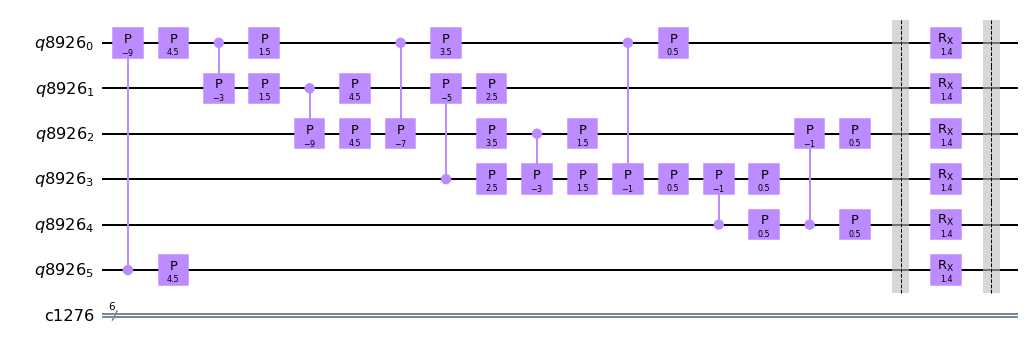

In [21]:
def HC_01(gamma,qc,qr,graph,nr_nodes):
    
    for edge in graph:
        qc.cp(-2*gamma*float(edge[2]),qr[edge[0]],qr[edge[1]])
        qc.p(gamma*float(edge[2]),qr[edge[0]])
        qc.p(gamma*float(edge[2]),qr[edge[1]])
                
    qc.barrier()

def HB_01(beta,qc,qr):
    
    for i in range(len(qr)):
        qc.rx(2*beta,qr[i])
    qc.barrier()


#Example:#   
qr=QuantumRegister(nr_nodes)
cr=ClassicalRegister(nr_nodes)
qc=QuantumCircuit(qr,cr)

HC_01(0.5,qc,qr,graph,nr_nodes)
HB_01(0.7,qc,qr,)

qc.draw('mpl')

In [22]:
def Init_H(qc,qr):
    for i in range(int(len(qr))):
        qc.h(qr[i])
    qc.barrier()

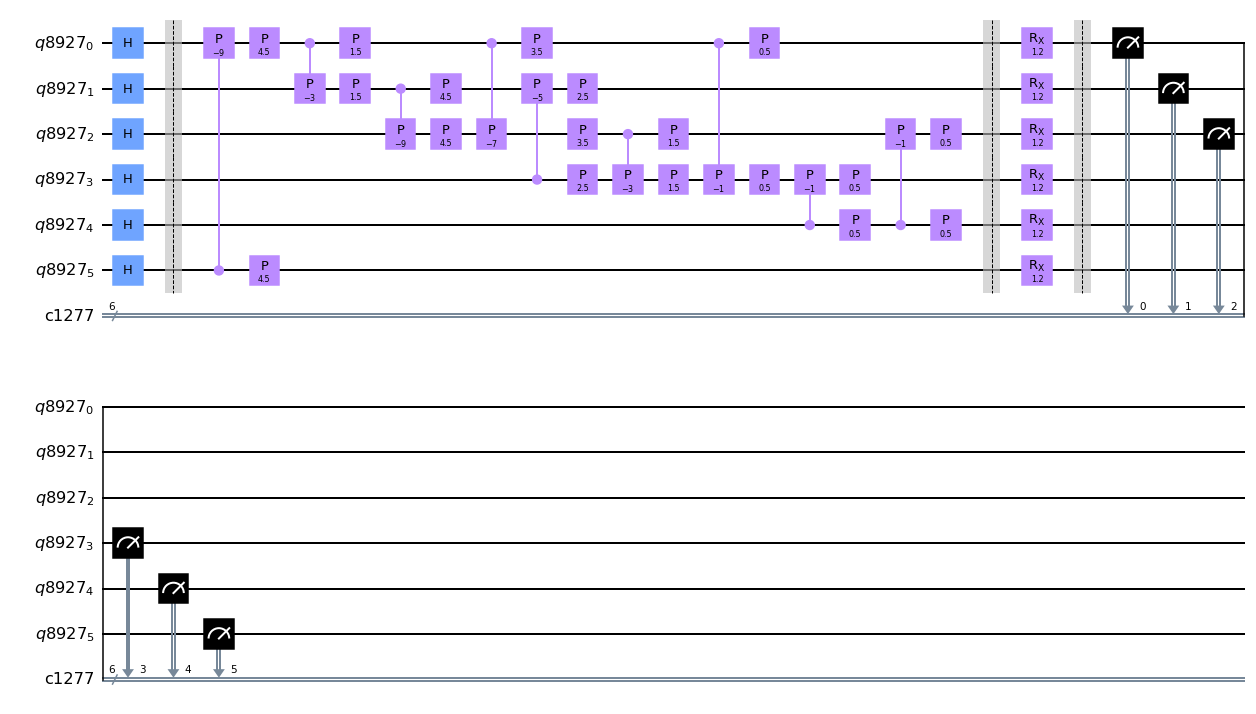

In [23]:
def QAOA_circ_01(graph,nr_nodes,params,l=1):
    
    qr=QuantumRegister(nr_nodes)
    cr=ClassicalRegister(nr_nodes)
    qc_QAOA=QuantumCircuit(qr,cr)
    
    Init_H(qc_QAOA,qr)
    for i in range(l):
        HC_01(params[i*2],qc_QAOA,qr,graph,nr_nodes)
        HB_01(params[i*2+1],qc_QAOA,qr)
    
    for i in range(nr_nodes):
        qc_QAOA.measure(qr[i],cr[i])
    return qc_QAOA

#Example:# 
QAOA_circ=QAOA_circ_01(graph,nr_nodes,[0.5,0.6],l=1)
QAOA_circ.draw('mpl') 

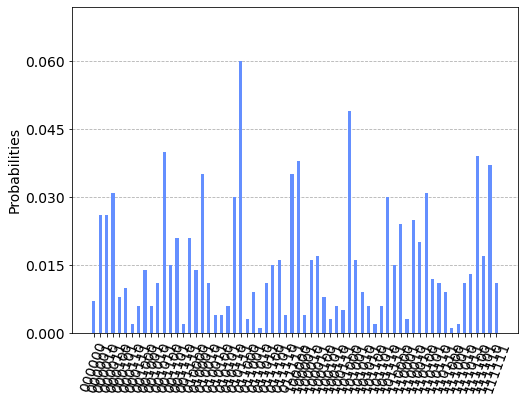

In [24]:
backend=Aer.get_backend("qasm_simulator")
shots=1000

simulate=execute(QAOA_circ, backend=backend, shots=shots)
counts=simulate.result().get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = False)

In [25]:
def expected_01(counts,graph,nr_nodes,shots):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]
        
    cost=0
    for x in counts:
        for i in range (nr_nodes):
            for j in range(i+1,nr_nodes):
                if x[i]!=x[j]:
                    cost=cost-W[i][j]*counts[x]
    cost=cost/shots
    return cost

#Example:# 
cost=expected_01(counts,graph,nr_nodes,shots)
print(cost)

-20.238


In [26]:
def QAOA_cost(params,graph,nr_nodes,l=1,
              backend=Aer.get_backend("qasm_simulator"),shots=1000):
    
    qc_QAOA=QAOA_circ_01(graph,nr_nodes,params,l=l)
    counts=execute(qc_QAOA, backend=backend, shots=shots).result().get_counts()
    cost=expected_01(counts,graph,nr_nodes,shots)
    return cost

#Example:#
cost=QAOA_cost([0.5,0.6],graph,nr_nodes,l=1,
                backend=Aer.get_backend("qasm_simulator"),shots=1000)
print(cost)

-20.813


Optimization terminated successfully    (Exit mode 0)
            Current function value: -16.218
            Iterations: 37
            Function evaluations: 627
            Gradient evaluations: 37
QAOA solutions:
('11101', 613)
('00010', 578)

 Clasic solutions:
Best cut (cost=24.0): 
- 00110
- 11001

 Parameters: [-2.36119253e+07 -2.18562480e+07 -5.92603936e+07  6.17128842e+07
  1.03370091e+08 -3.70819514e+07]
Quantum state cost -16.1954


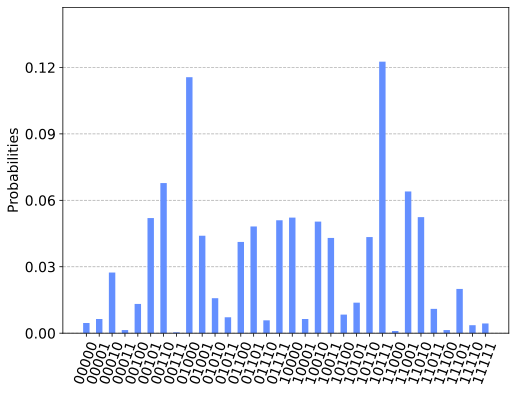

In [39]:
def MaxCut_01(graph,nr_nodes,l=1,params=[0.5,0.3],nr_s=2,shots=5000,method='COBYLA'):
    
    optim=minimize(QAOA_cost, params ,args=(graph,nr_nodes,l),method=method, 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 
                            'disp': True, 'catol': 0.0002})
    QAOA_circ=QAOA_circ_01(graph,nr_nodes,optim.x,l=l)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
    
    o=0
    sol=[]
    for i in counts:
        sol.append((i[::-1],counts[i]))
        if len(sol)==nr_s:
            break
            
    return optim.x,counts,sol

#Example:#
para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.5,0.3,0.5,0.3,0.7,0.2],l=2,method='SLSQP')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)



QAOA solutions:
('11100', 543)
('00011', 528)

 Clasic solutions:
Best cut (cost=24.0): 
- 00110
- 11001

 Parameters: [ 3.06747744 -0.0876113   1.65879947  0.49207628  1.90066558  1.32443543]
Quantum state cost -16.8848


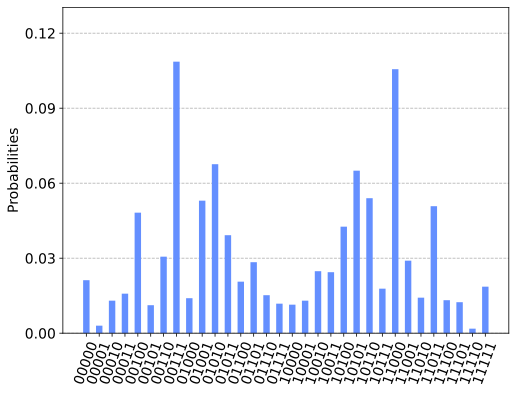

In [38]:
#Test2#

graph=[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
nr_nodes=5

para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.900,0.2,1.900,0.2,1.900,0.2],l=3,method='COBYLA')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

QAOA solutions:
('001001', 251)
('110110', 227)

 Clasic solutions:
Best cut (cost=33.0): 
- 110010
- 001101

 Parameters: [ 1.56807245 -0.21654768]
Quantum state cost -21.4976


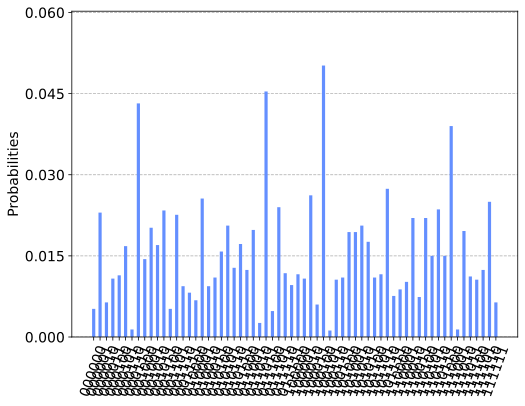

In [37]:
#Test3#

graph=[(5,0,9.0),(0,1,3.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
nr_nodes=6

para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.900,0.2],l=1,method='COBYLA')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

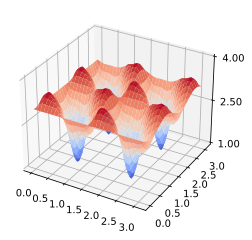


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [35]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))